<a href="https://colab.research.google.com/github/prof-eduardo-nunes/unicamp-mineracao_dados/blob/main/Aula_Pratica_YOLOv8_Tomates_Roboflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula Prática: Detecção de Tomates com YOLOv8
## Dataset Pré-Anotado do Roboflow

**Objetivo:** Treinar um modelo de detecção de tomates usando YOLOv8 com um dataset já anotado e pronto para uso.

**Dataset:** Find Tomatoes (Roboflow Universe)
- 16 imagens totais (12 treino, 2 validação, 2 teste)
- Anotações em formato YOLO
- Classe: `tomato`

**Aplicações:**
- Colheita automatizada
- Monitoramento de lavoura
- Contagem de frutos
- Estimativa de produção

---

## Parte 1: Configuração do Ambiente

Vamos instalar as bibliotecas necessárias para trabalhar com YOLOv8 e Roboflow.

In [1]:
# Instalação das bibliotecas
!pip install ultralytics roboflow -q

print("✓ Bibliotecas instaladas com sucesso!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 32.2 MB/s eta 0:00:00
✓ Bibliotecas instaladas com sucesso!


In [2]:
# Importar bibliotecas
from ultralytics import YOLO
from roboflow import Roboflow
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
from pathlib import Path

print("✓ Bibliotecas importadas!")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✓ Bibliotecas importadas!


## Parte 2: Download do Dataset

Vamos baixar o dataset de tomates já anotado do Roboflow Universe.

In [3]:
# Inicializar Roboflow com API key
rf = Roboflow(api_key="RRik3EcVITfqN1dDeck9")

# Acessar o projeto
project = rf.workspace("identificao-de-tomates").project("find-tomatoes-um0de")
version = project.version(1)

# Download do dataset no formato YOLOv8
dataset = version.download("yolov8")

print(f"\n✓ Dataset baixado com sucesso!")
print(f"Localização: {dataset.location}")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Find-tomatoes-1 in yolov8:: 100%|██████████| 44/44 [00:00<00:00, 5519.98it/s]


✓ Dataset baixado com sucesso!
Localização: /content/Find-tomatoes-1


### 2.1. Explorar Estrutura do Dataset

In [4]:
# Verificar estrutura do dataset
dataset_path = Path(dataset.location)

print("\n📊 Estrutura do Dataset:")
print("=" * 50)

for split in ['train', 'valid', 'test']:
    img_dir = dataset_path / split / 'images'
    lbl_dir = dataset_path / split / 'labels'

    if img_dir.exists():
        num_images = len(list(img_dir.glob('*')))
        num_labels = len(list(lbl_dir.glob('*.txt'))) if lbl_dir.exists() else 0

        print(f"\n{split.upper()}:")
        print(f"  Imagens: {num_images}")
        print(f"  Anotações: {num_labels}")


📊 Estrutura do Dataset:

TRAIN:
  Imagens: 12
  Anotações: 12

VALID:
  Imagens: 2
  Anotações: 2

TEST:
  Imagens: 2
  Anotações: 2


### 2.2. Visualizar Arquivo de Configuração

In [5]:
# Ler e exibir data.yaml
yaml_path = dataset_path / 'data.yaml'

print("\n📄 Conteúdo do data.yaml:")
print("=" * 50)

with open(yaml_path, 'r') as f:
    yaml_content = f.read()
    print(yaml_content)

print("\n✓ Dataset configurado com:")
print("  - 1 classe: tomato")
print("  - Formato: YOLOv8")
print("  - Anotações: Bounding boxes")


📄 Conteúdo do data.yaml:
names:
- tomato
nc: 1
roboflow:
  license: Public Domain
  project: find-tomatoes-um0de
  url: https://universe.roboflow.com/identificao-de-tomates/find-tomatoes-um0de/dataset/1
  version: 1
  workspace: identificao-de-tomates
test: ../test/images
train: ../train/images
val: ../valid/images


✓ Dataset configurado com:
  - 1 classe: tomato
  - Formato: YOLOv8
  - Anotações: Bounding boxes


## Parte 3: Visualização do Dataset

Vamos visualizar algumas imagens com suas anotações para entender o dataset.

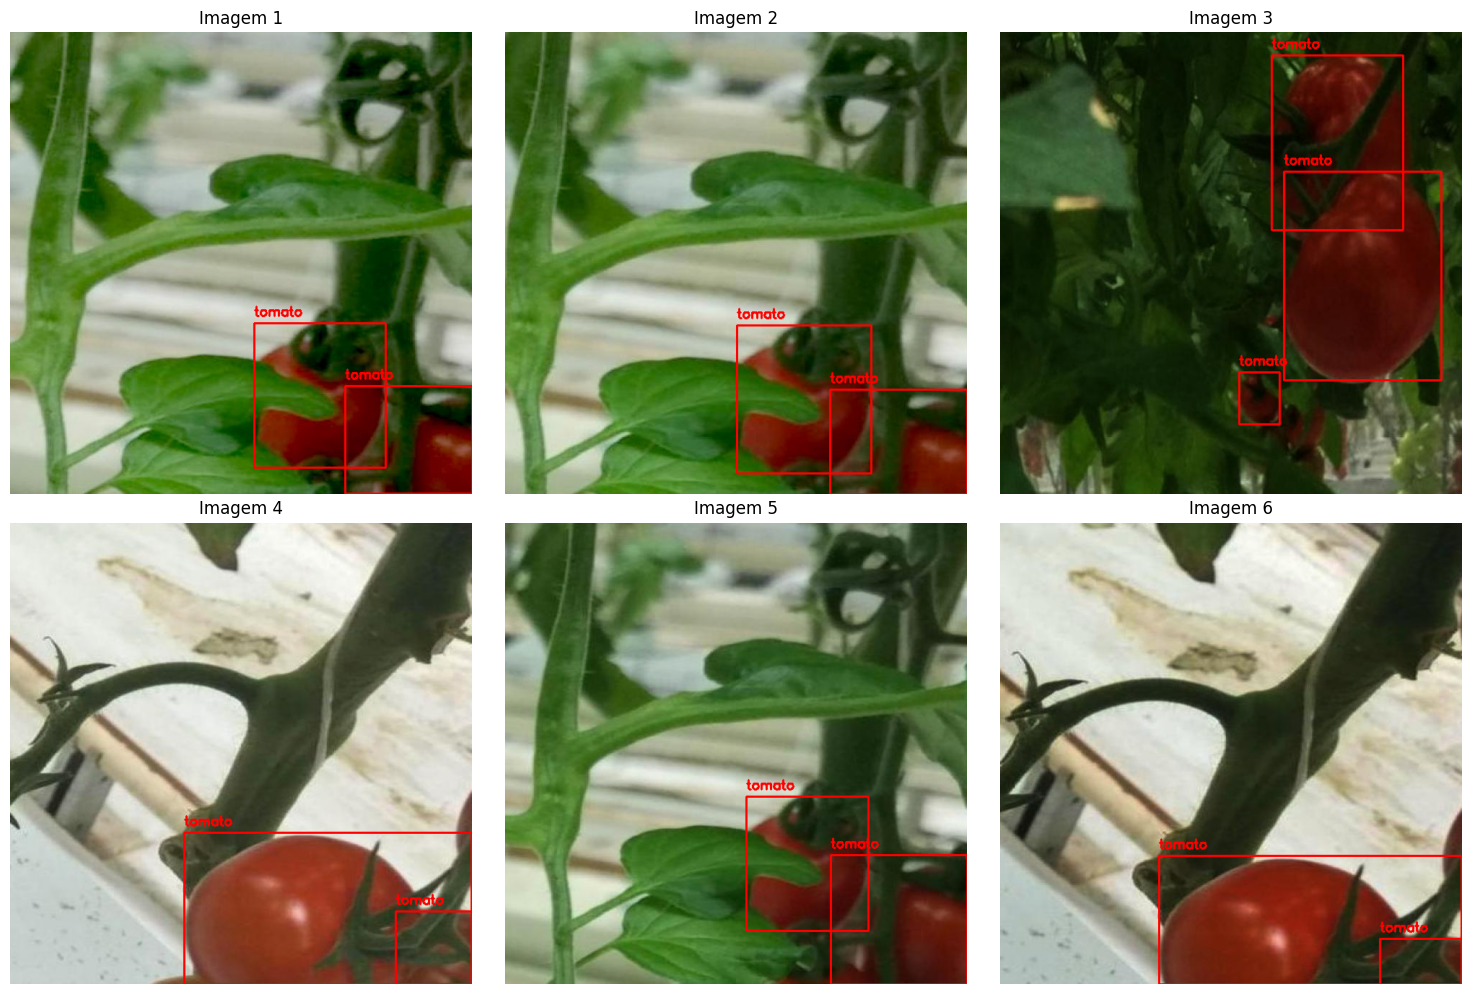


✓ Imagens com anotações visualizadas!


In [6]:
def visualizar_anotacoes(img_path, label_path, class_names=['tomato']):
    """
    Visualiza uma imagem com suas bounding boxes
    """
    # Carregar imagem
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    # Ler anotações
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f.readlines():
                # Formato YOLO: class x_center y_center width height
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id, x_center, y_center, width, height = map(float, parts)

                    # Converter para coordenadas absolutas
                    x_center *= w
                    y_center *= h
                    width *= w
                    height *= h

                    # Calcular cantos
                    x1 = int(x_center - width/2)
                    y1 = int(y_center - height/2)
                    x2 = int(x_center + width/2)
                    y2 = int(y_center + height/2)

                    # Desenhar bounding box
                    color = (255, 0, 0)  # Vermelho
                    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

                    # Adicionar label
                    label = class_names[int(class_id)]
                    cv2.putText(img, label, (x1, y1-10),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    return img

# Visualizar imagens de treino
train_images_dir = dataset_path / 'train' / 'images'
train_labels_dir = dataset_path / 'train' / 'labels'

image_files = list(train_images_dir.glob('*.jpg'))[:6]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, img_path in enumerate(image_files):
    label_path = train_labels_dir / f"{img_path.stem}.txt"

    img_with_boxes = visualizar_anotacoes(img_path, label_path)

    axes[idx].imshow(img_with_boxes)
    axes[idx].axis('off')
    axes[idx].set_title(f"Imagem {idx+1}")

plt.tight_layout()
plt.show()

print("\n✓ Imagens com anotações visualizadas!")

## Parte 4: Treinamento do Modelo YOLOv8

Agora vamos treinar nosso modelo de detecção de tomates.

### 4.1. Escolher Modelo Base

O YOLOv8 oferece diferentes tamanhos:

| Modelo | Tamanho | Velocidade | Precisão | Uso Recomendado |
|--------|---------|------------|----------|------------------|
| YOLOv8n | Nano | Muito rápido | Baixa | Dispositivos móveis |
| YOLOv8s | Small | Rápido | Boa | Equilíbrio geral |
| YOLOv8m | Medium | Médio | Muito boa | Aplicações gerais |
| YOLOv8l | Large | Lento | Alta | Alta precisão |
| YOLOv8x | Extra Large | Muito lento | Muito alta | Máxima precisão |

Para esta aula, usaremos **YOLOv8s** (small) que oferece um bom equilíbrio.

In [7]:
# Inicializar modelo YOLOv8
model = YOLO('yolov8s.pt')  # Carrega modelo pré-treinado no COCO

print("✓ Modelo YOLOv8s carregado!")
print("\nO modelo será treinado usando transfer learning,")
print("partindo dos pesos pré-treinados no dataset COCO.")

✓ Modelo YOLOv8s carregado!

O modelo será treinado usando transfer learning,
partindo dos pesos pré-treinados no dataset COCO.


### 4.2. Configurar e Executar Treinamento

In [10]:
# Treinar o modelo
results = model.train(
    data=f"{dataset.location}/data.yaml",  # Caminho para data.yaml
    epochs=5,                              # Número de épocas
    imgsz=640,                              # Tamanho da imagem
    batch=8,                                # Tamanho do batch (ajuste conforme GPU)
    name='tomato_detector',                 # Nome do experimento
    patience=10,                            # Early stopping
    save=True,                              # Salvar checkpoints
    device='cpu',                               # GPU (use 'cpu' se não tiver GPU)
    workers=2,                              # Workers para carregamento
    project='runs/detect',                  # Diretório do projeto
    exist_ok=True,                          # Sobrescrever se existir
    pretrained=True,                        # Usar pesos pré-treinados
    optimizer='auto',                       # Otimizador automático
    verbose=True,                           # Mostrar progresso
    seed=42,                                # Seed para reprodutibilidade
    deterministic=True,                     # Treinamento determinístico
    single_cls=True,                        # Uma única classe
    rect=False,                             # Treinamento retangular
    cos_lr=False,                           # Cosine learning rate
    close_mosaic=10,                        # Desabilitar mosaic nas últimas N épocas
    resume=False,                           # Retomar treinamento
    amp=True,                               # Automatic Mixed Precision
    fraction=1.0,                           # Fração do dataset a usar
    profile=False,                          # Profiling
    overlap_mask=True,                      # Máscaras sobrepostas
    val=True,                               # Validar durante treinamento
)

print("\n" + "=" * 60)
print("✓ TREINAMENTO CONCLUÍDO!")
print("=" * 60)

Ultralytics 8.3.216 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Find-tomatoes-1/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=tomato_detector, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plot

### 4.3. Visualizar Resultados do Treinamento

📊 Curvas de Treinamento:


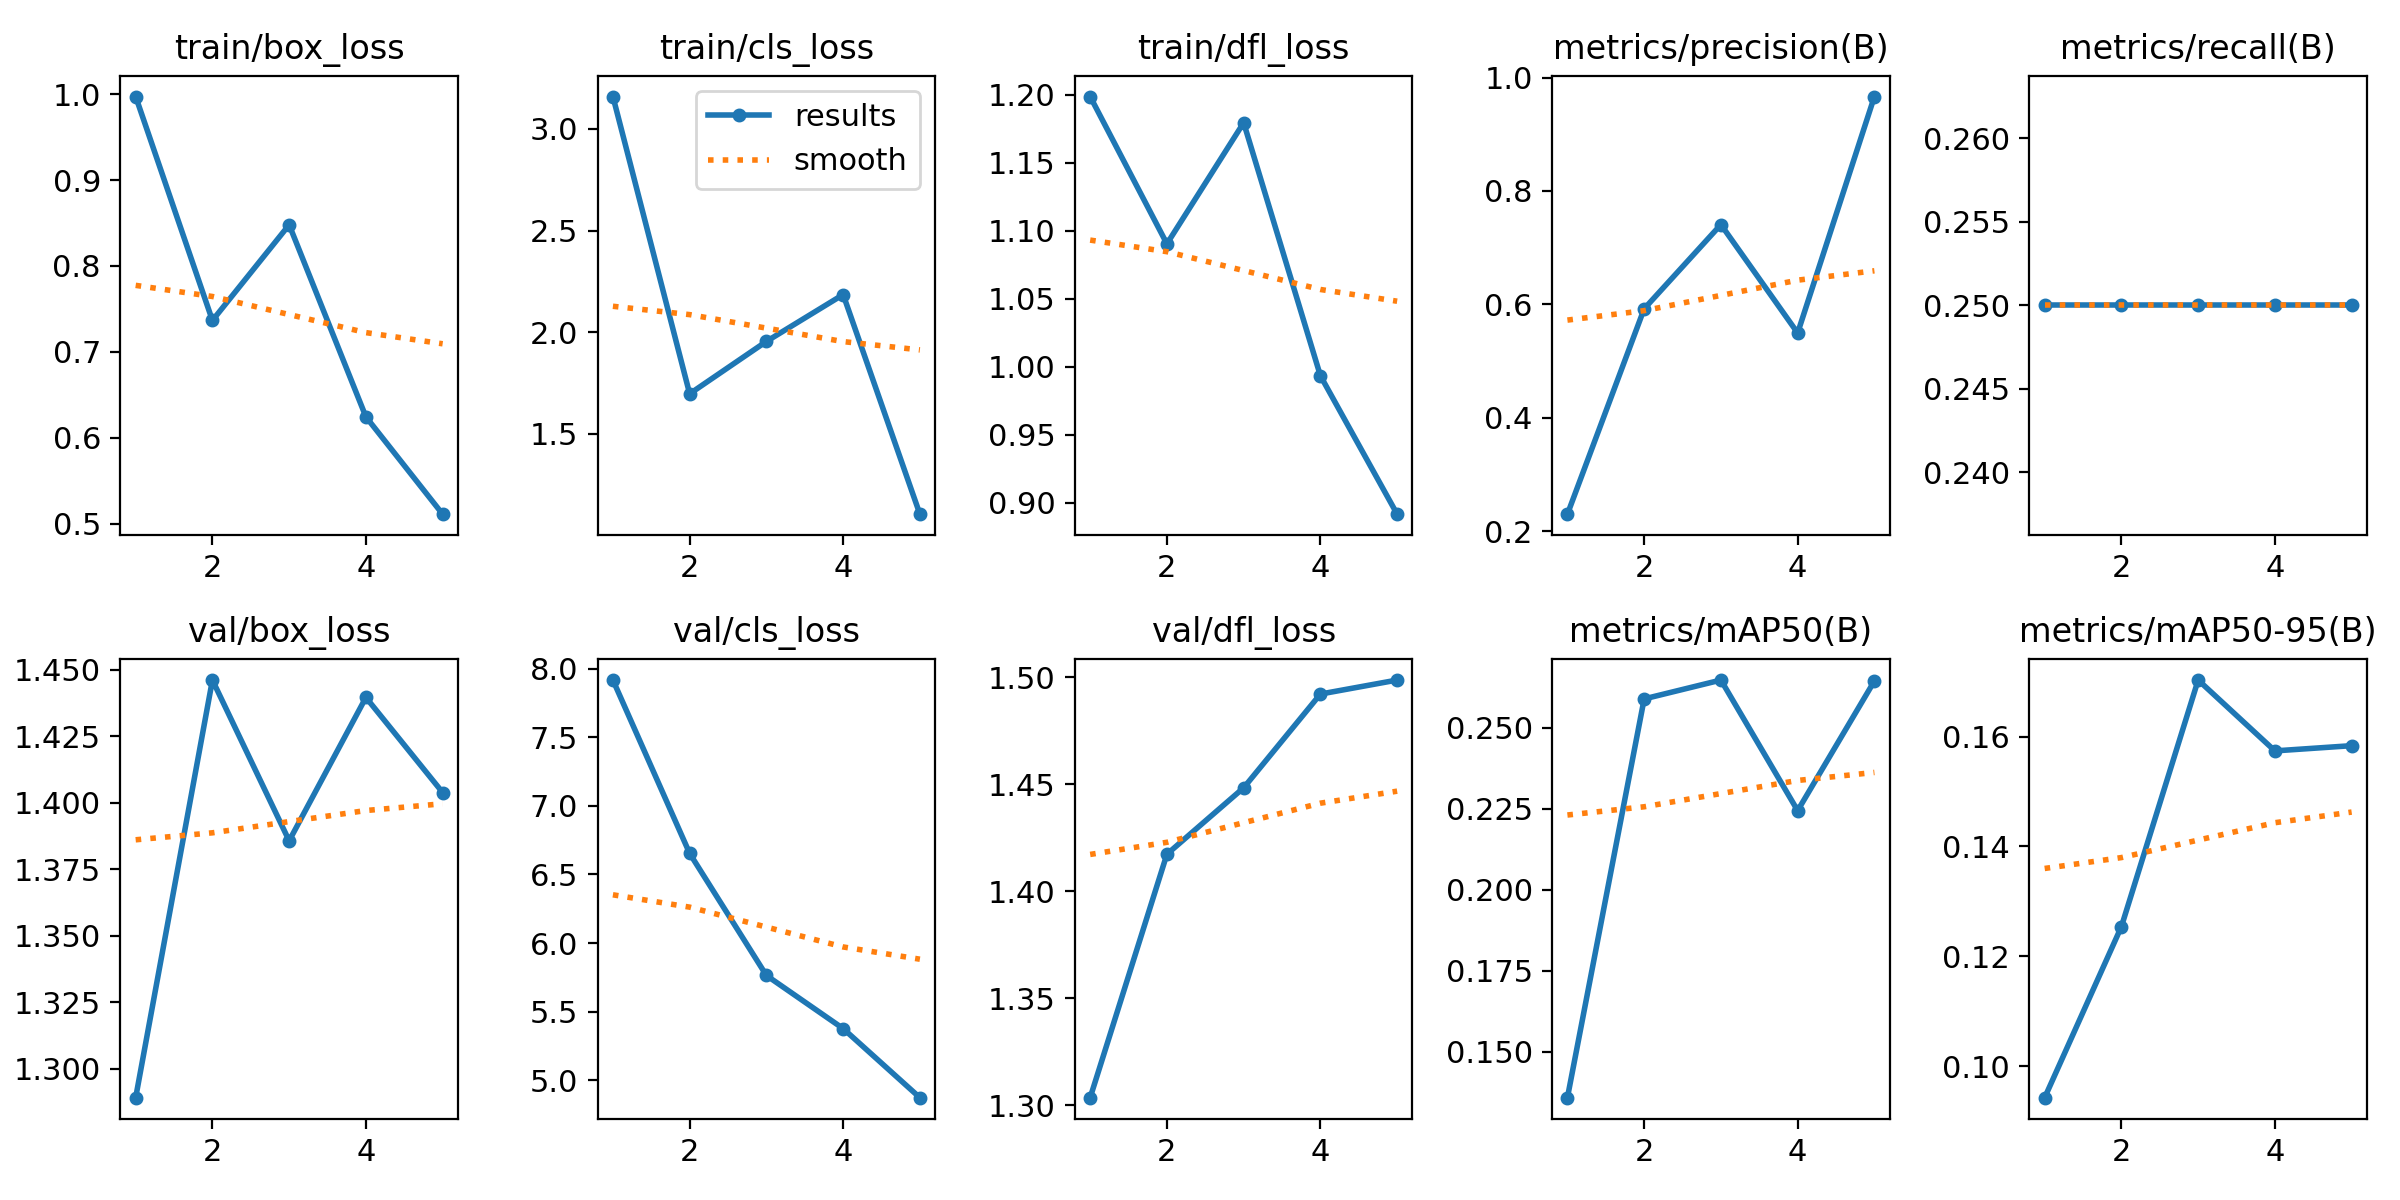

In [11]:
# Visualizar gráficos de treinamento
from IPython.display import Image as IPImage

results_path = 'runs/detect/tomato_detector/results.png'

if os.path.exists(results_path):
    print("📊 Curvas de Treinamento:")
    display(IPImage(filename=results_path, width=900))
else:
    print("⚠️  Arquivo de resultados não encontrado.")
    print(f"Verifique o diretório: runs/detect/tomato_detector/")

## Parte 5: Validação do Modelo

Vamos avaliar o desempenho do modelo treinado.

In [12]:
# Carregar o melhor modelo treinado
best_model = YOLO('runs/detect/tomato_detector/weights/best.pt')

print("✓ Melhor modelo carregado!")
print("\nExecutando validação...")

# Validar o modelo
metrics = best_model.val()

# Exibir métricas
print("\n" + "=" * 60)
print("📊 MÉTRICAS DE VALIDAÇÃO")
print("=" * 60)
print(f"\nmAP@0.5:      {metrics.box.map50:.4f}")
print(f"mAP@0.5:0.95: {metrics.box.map:.4f}")
print(f"Precisão:     {metrics.box.mp:.4f}")
print(f"Recall:       {metrics.box.mr:.4f}")

print("\n" + "=" * 60)
print("Interpretação das Métricas:")
print("=" * 60)
print("mAP@0.5:      Precisão média com IoU threshold de 50%")
print("mAP@0.5:0.95: Precisão média em múltiplos thresholds")
print("Precisão:     % de detecções corretas")
print("Recall:       % de objetos detectados")
print("=" * 60)

✓ Melhor modelo carregado!

Executando validação...
Ultralytics 8.3.216 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 614.9±91.1 MB/s, size: 32.2 KB)
val: Scanning /content/Find-tomatoes-1/valid/labels.cache... 2 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2/2 1.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 0.8it/s 1.2s
                   all          2          8      0.744       0.25      0.265       0.17
Speed: 2.4ms preprocess, 582.5ms inference, 0.0ms loss, 17.8ms postprocess per image
Results saved to /content/runs/detect/val

📊 MÉTRICAS DE VALIDAÇÃO

mAP@0.5:      0.2647
mAP@0.5:0.95: 0.1703
Precisão:     0.7441
Recall:       0.2500

Interpretação das Métricas:
mAP@0.5:      Precisão média com IoU threshold de 50%
mAP@0.5:0.95: Precisão média em

### 5.1. Visualizar Matriz de Confusão

📊 Matriz de Confusão:


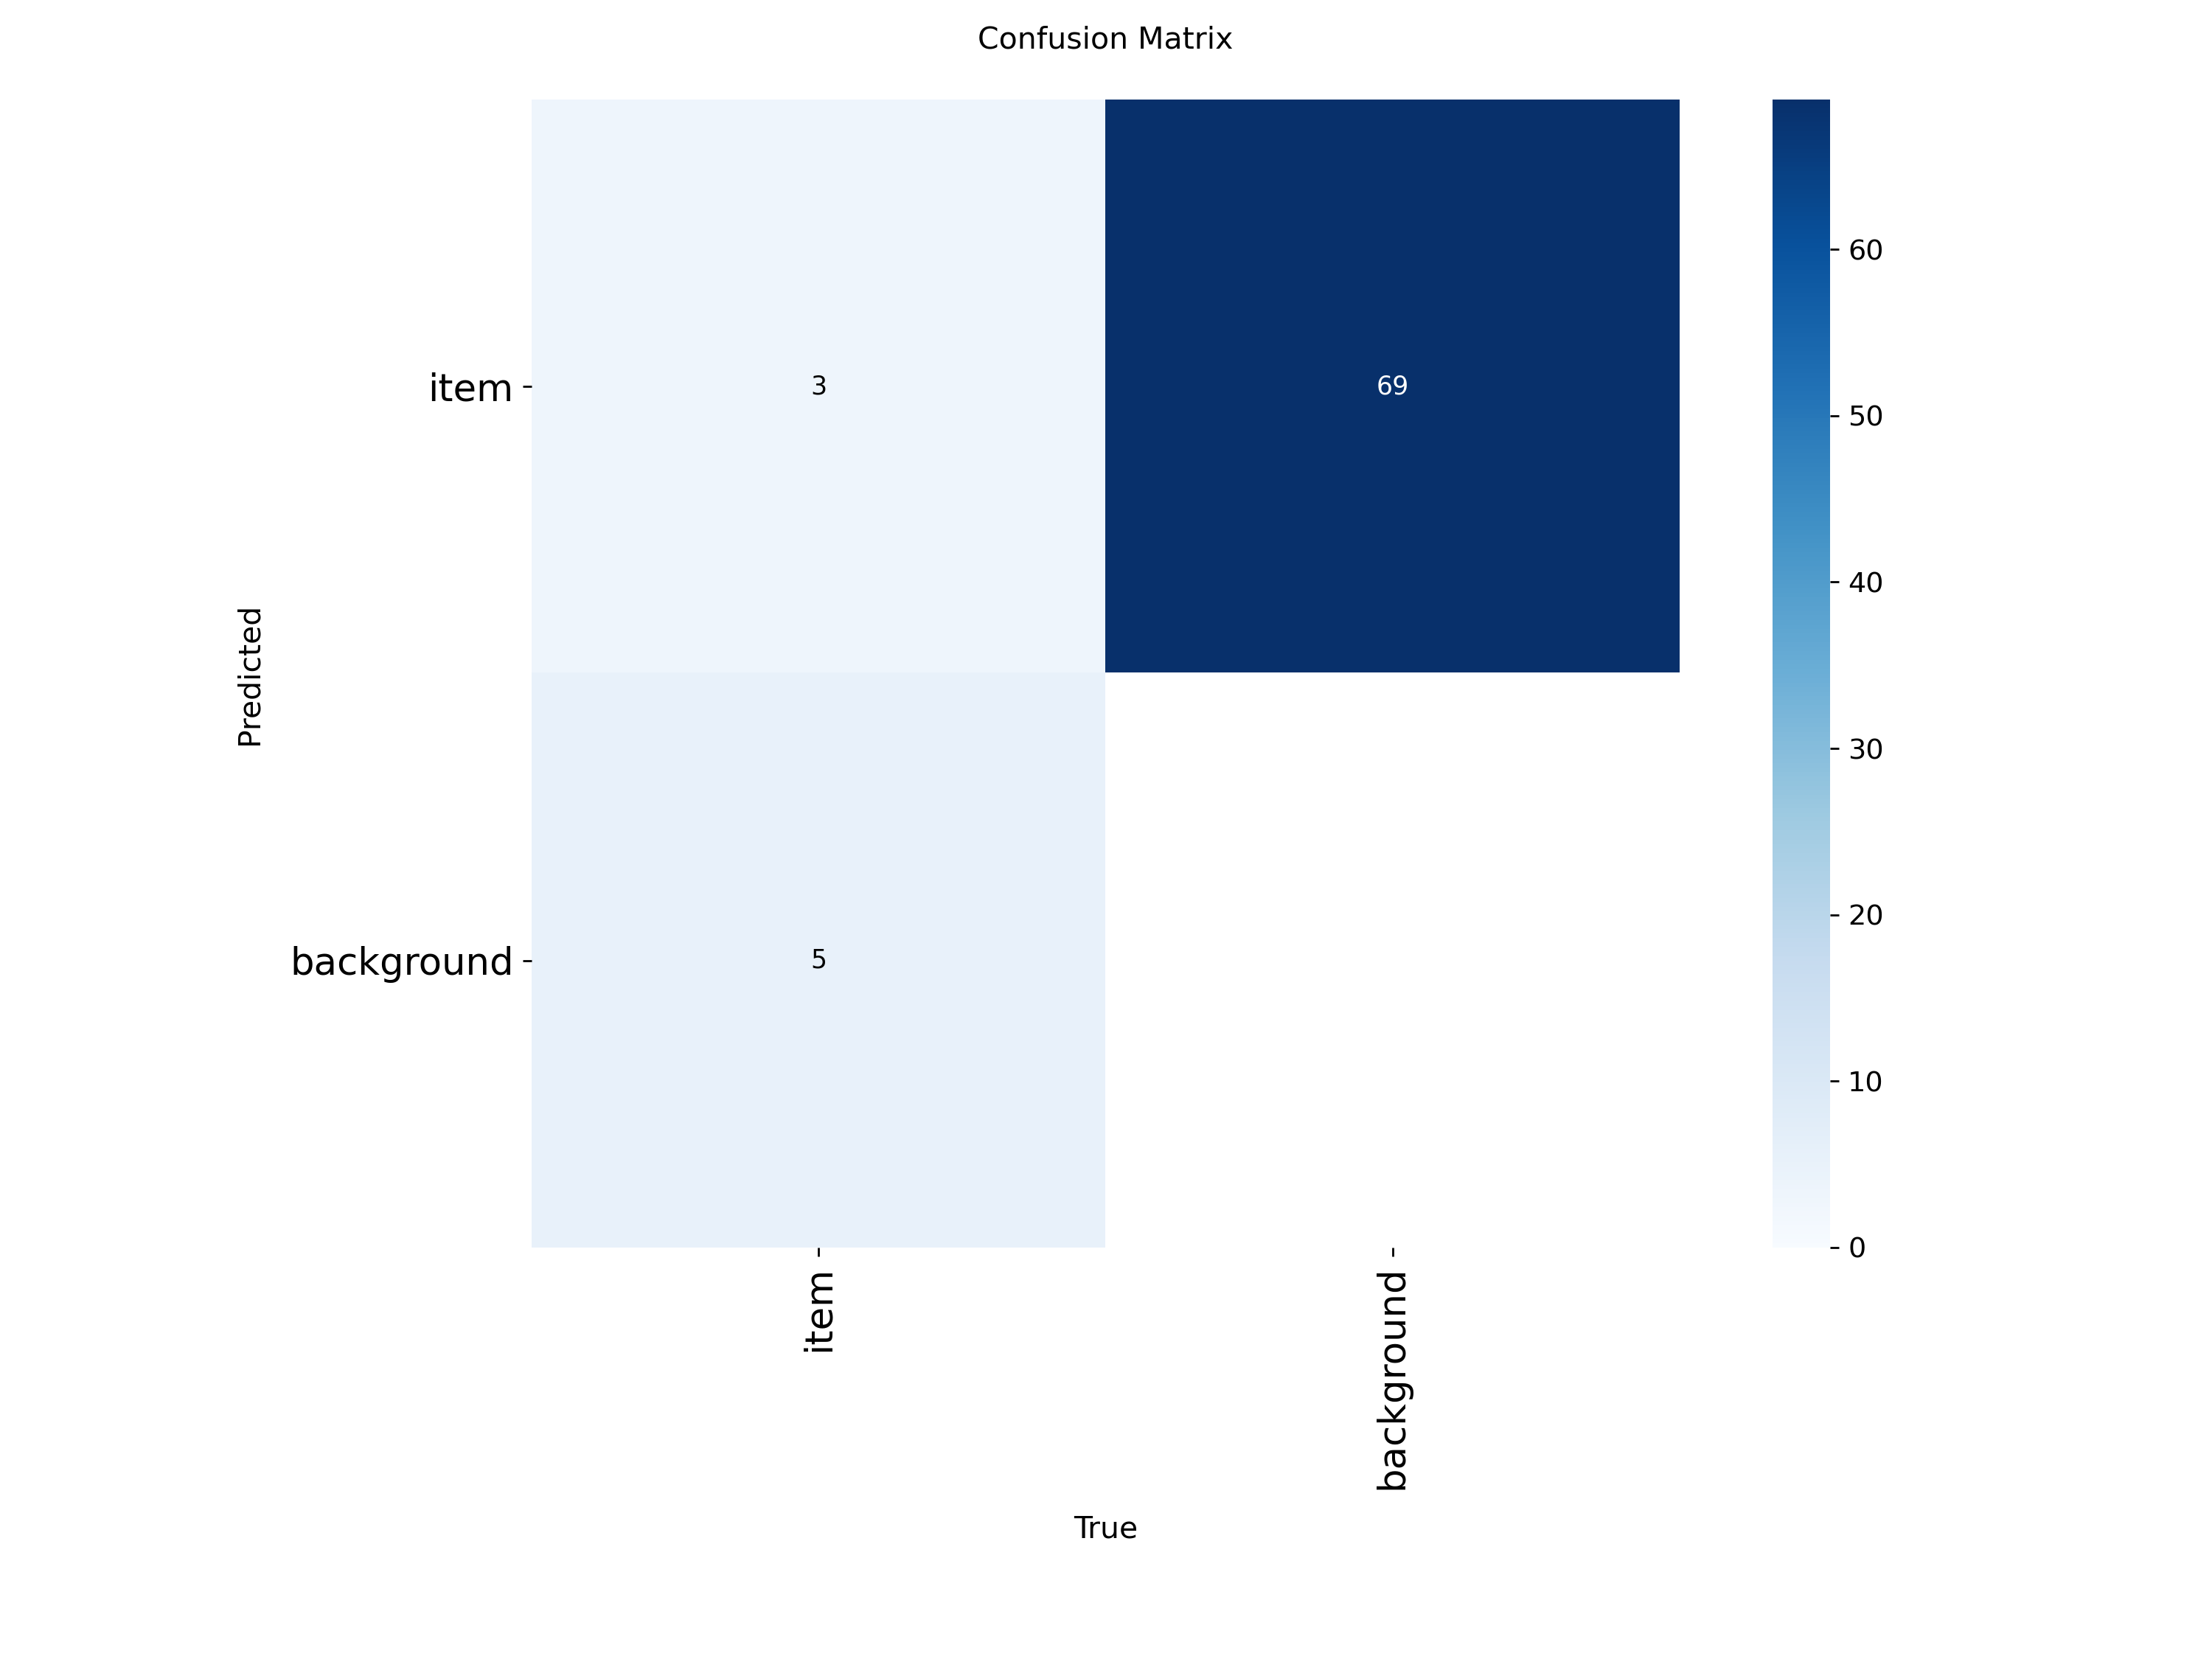

In [13]:
# Matriz de confusão
confusion_matrix_path = 'runs/detect/tomato_detector/confusion_matrix.png'

if os.path.exists(confusion_matrix_path):
    print("📊 Matriz de Confusão:")
    display(IPImage(filename=confusion_matrix_path, width=600))
else:
    print("⚠️  Matriz de confusão não encontrada.")

### 5.2. Visualizar Exemplos de Predições

📊 Exemplos de Predições (Validação):


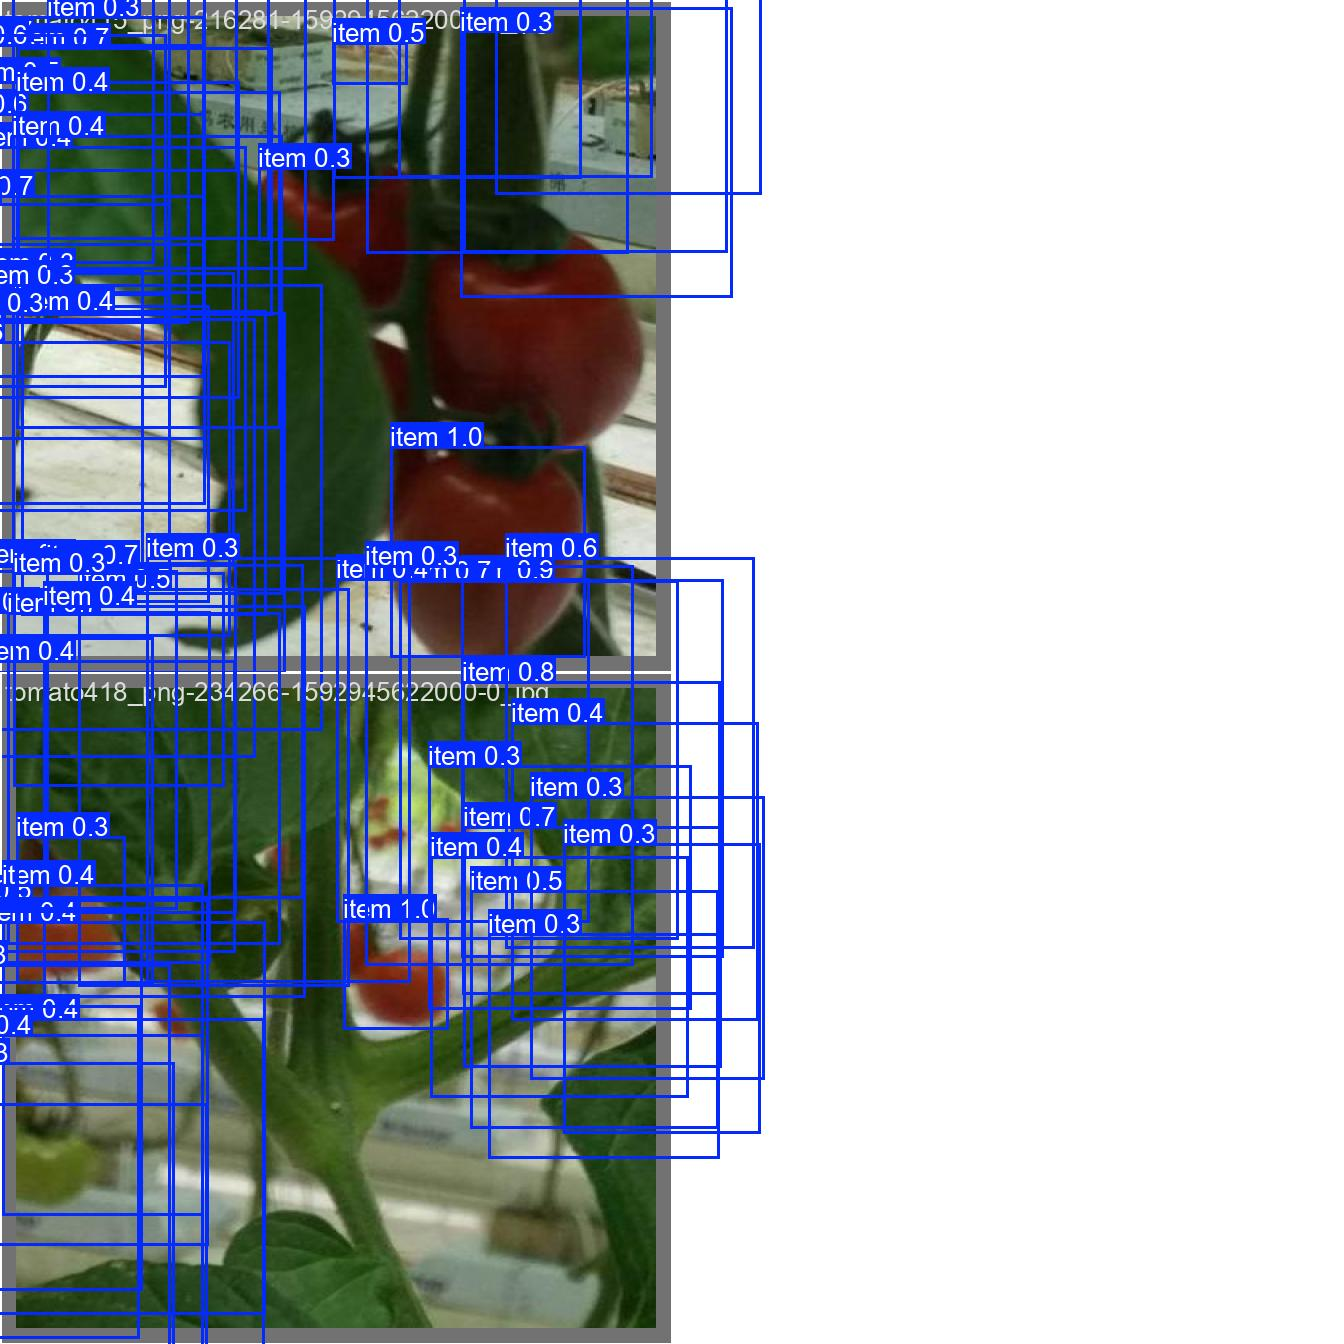

In [14]:
# Exemplos de predições no conjunto de validação
val_batch_path = 'runs/detect/tomato_detector/val_batch0_pred.jpg'

if os.path.exists(val_batch_path):
    print("📊 Exemplos de Predições (Validação):")
    display(IPImage(filename=val_batch_path, width=900))
else:
    print("⚠️  Arquivo de predições não encontrado.")

## Parte 6: Inferência em Novas Imagens

Agora vamos usar nosso modelo para detectar tomates em novas imagens.

### 6.1. Testar no Conjunto de Teste

Testando em 2 imagens do conjunto de teste...



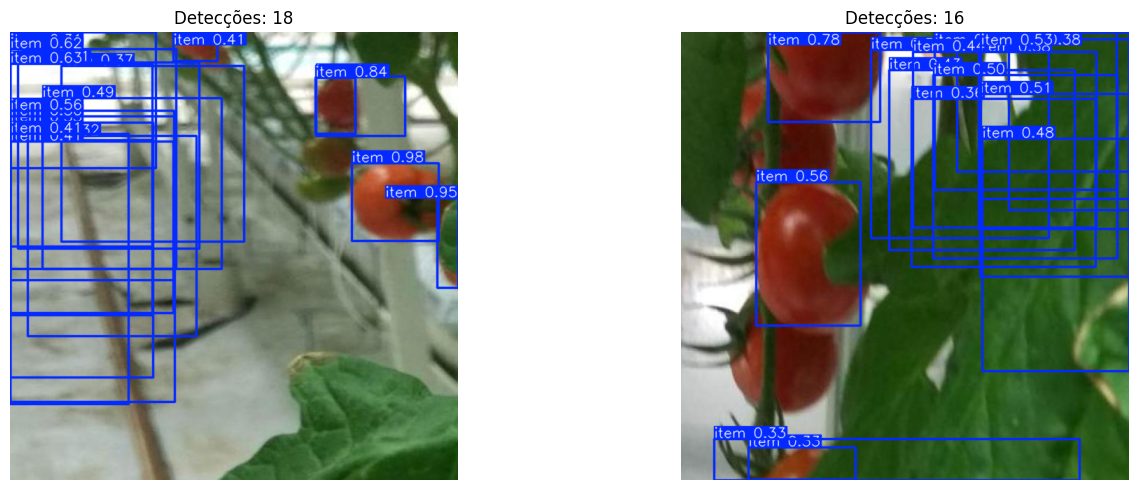


✓ Inferência concluída!


In [15]:
def detectar_tomates(image_path, model, conf_threshold=0.25):
    """
    Detecta tomates em uma imagem e retorna resultado visualizado
    """
    # Fazer predição
    results = model.predict(
        source=image_path,
        conf=conf_threshold,
        save=False,
        show=False,
        verbose=False
    )

    # Plotar resultado
    result_img = results[0].plot()
    result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

    return result_img, results[0]

# Testar em imagens do conjunto de teste
test_images_dir = dataset_path / 'test' / 'images'
test_images = list(test_images_dir.glob('*.jpg'))

print(f"Testando em {len(test_images)} imagens do conjunto de teste...\n")

fig, axes = plt.subplots(1, len(test_images), figsize=(15, 5))
if len(test_images) == 1:
    axes = [axes]

for idx, img_path in enumerate(test_images):
    result_img, result = detectar_tomates(str(img_path), best_model, conf_threshold=0.3)

    axes[idx].imshow(result_img)
    axes[idx].axis('off')
    axes[idx].set_title(f"Detecções: {len(result.boxes)}")

plt.tight_layout()
plt.show()

print("\n✓ Inferência concluída!")

### 6.2. Análise Detalhada de uma Predição

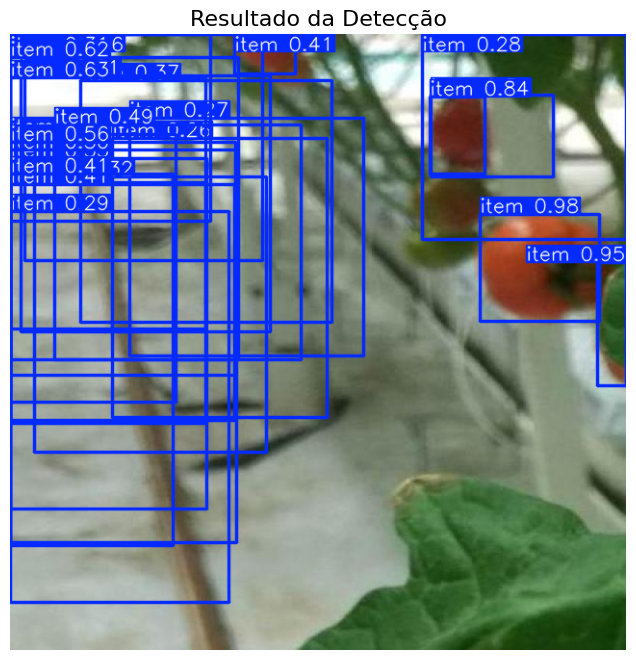


ANÁLISE DETALHADA DA DETECÇÃO

Imagem: tomato396_png-218755-1592945620000-0_jpg.rf.75a70ae8372e7e8660a2f75e8a436d95.jpg
Total de tomates detectados: 24

Detecção 1:
  Classe: item
  Confiança: 98.27%
  Coordenadas: (489, 187) - (612, 299)

Detecção 2:
  Classe: item
  Confiança: 94.65%
  Coordenadas: (610, 237) - (640, 366)

Detecção 3:
  Classe: item
  Confiança: 83.87%
  Coordenadas: (437, 65) - (494, 146)

Detecção 4:
  Classe: item
  Confiança: 63.42%
  Coordenadas: (0, 46) - (204, 307)

Detecção 5:
  Classe: item
  Confiança: 61.59%
  Coordenadas: (0, 25) - (238, 339)

Detecção 6:
  Classe: item
  Confiança: 61.06%
  Coordenadas: (11, 43) - (270, 310)

Detecção 7:
  Classe: item
  Confiança: 56.43%
  Coordenadas: (0, 112) - (235, 354)

Detecção 8:
  Classe: item
  Confiança: 50.30%
  Coordenadas: (0, 121) - (236, 529)

Detecção 9:
  Classe: item
  Confiança: 48.98%
  Coordenadas: (47, 95) - (302, 339)

Detecção 10:
  Classe: item
  Confiança: 41.46%
  Coordenadas: (0, 145) - (170

In [16]:
# Analisar primeira imagem de teste em detalhes
if test_images:
    test_img_path = str(test_images[0])
    result_img, result = detectar_tomates(test_img_path, best_model, conf_threshold=0.25)

    # Mostrar imagem
    plt.figure(figsize=(12, 8))
    plt.imshow(result_img)
    plt.axis('off')
    plt.title("Resultado da Detecção", fontsize=16)
    plt.show()

    # Informações detalhadas
    print("\n" + "=" * 60)
    print("ANÁLISE DETALHADA DA DETECÇÃO")
    print("=" * 60)
    print(f"\nImagem: {Path(test_img_path).name}")
    print(f"Total de tomates detectados: {len(result.boxes)}\n")

    for idx, box in enumerate(result.boxes, 1):
        class_id = int(box.cls[0])
        confidence = float(box.conf[0])
        class_name = result.names[class_id]

        # Coordenadas da bounding box
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()

        print(f"Detecção {idx}:")
        print(f"  Classe: {class_name}")
        print(f"  Confiança: {confidence:.2%}")
        print(f"  Coordenadas: ({x1:.0f}, {y1:.0f}) - ({x2:.0f}, {y2:.0f})")
        print()
else:
    print("⚠️  Nenhuma imagem de teste encontrada.")

### 6.3. Upload e Teste em Imagem Própria

In [ ]:
# Upload de imagem para teste
from google.colab import files

print("📤 Faça upload de uma imagem de tomate para testar o modelo:")
uploaded = files.upload()

# Processar cada imagem enviada
for filename in uploaded.keys():
    print(f"\nProcessando: {filename}")

    result_img, result = detectar_tomates(filename, best_model, conf_threshold=0.25)

    # Visualizar
    plt.figure(figsize=(12, 8))
    plt.imshow(result_img)
    plt.axis('off')
    plt.title(f"Resultado: {len(result.boxes)} tomates detectados", fontsize=16)
    plt.show()

    # Detalhes
    print(f"\n✓ Detecções em {filename}:")
    for i, box in enumerate(result.boxes, 1):
        confidence = float(box.conf[0])
        print(f"  {i}. Tomate detectado com {confidence:.1%} de confiança")

## Parte 7: Processamento de Vídeo (Opcional)

O modelo também pode processar vídeos para detecção em tempo real.

In [ ]:
# Exemplo de processamento de vídeo
# Descomente e ajuste o caminho do vídeo

# video_path = 'path/to/video.mp4'
# results = best_model.predict(
#     source=video_path,
#     conf=0.3,
#     save=True,
#     show=False,
#     stream=True  # Streaming para vídeos longos
# )

# # Processar frame por frame
# for result in results:
#     # Processar cada frame
#     pass

print("💡 Para processar vídeos:")
print("1. Descomente o código acima")
print("2. Forneça o caminho do vídeo")
print("3. Execute a célula")
print("\nO vídeo processado será salvo em runs/detect/predict/")

## Parte 8: Exportação do Modelo

Para usar o modelo em produção ou dispositivos embarcados, podemos exportá-lo para diferentes formatos.

In [ ]:
# Exportar para ONNX (formato universal)
print("Exportando modelo para ONNX...")
onnx_path = best_model.export(format='onnx')

print(f"\n✓ Modelo exportado para: {onnx_path}")
print("\nOutros formatos disponíveis:")
print("  - torchscript: PyTorch TorchScript")
print("  - tflite: TensorFlow Lite (dispositivos móveis)")
print("  - coreml: CoreML (iOS)")
print("  - engine: TensorRT (GPUs NVIDIA)")
print("  - openvino: OpenVINO (Intel)")
print("\nExemplo:")
print("  best_model.export(format='tflite')")

## Parte 9: Estatísticas e Análise Final

In [ ]:
# Resumo do projeto
print("=" * 60)
print("RESUMO DO PROJETO")
print("=" * 60)

print("\n📊 Dataset:")
print(f"  - Fonte: Roboflow Universe")
print(f"  - Total de imagens: 16")
print(f"  - Treino: 12 imagens")
print(f"  - Validação: 2 imagens")
print(f"  - Teste: 2 imagens")
print(f"  - Classes: 1 (tomato)")

print("\n🤖 Modelo:")
print(f"  - Arquitetura: YOLOv8s")
print(f"  - Transfer Learning: Sim (COCO)")
print(f"  - Épocas: 50")
print(f"  - Tamanho de imagem: 640x640")

print("\n📈 Resultados:")
print(f"  - mAP@0.5: {metrics.box.map50:.4f}")
print(f"  - mAP@0.5:0.95: {metrics.box.map:.4f}")
print(f"  - Precisão: {metrics.box.mp:.4f}")
print(f"  - Recall: {metrics.box.mr:.4f}")

print("\n💾 Arquivos Gerados:")
print(f"  - Melhor modelo: runs/detect/tomato_detector/weights/best.pt")
print(f"  - Último modelo: runs/detect/tomato_detector/weights/last.pt")
print(f"  - Gráficos: runs/detect/tomato_detector/results.png")
print(f"  - Modelo ONNX: {onnx_path}")

print("\n" + "=" * 60)

## Conclusão

### ✅ O que aprendemos:

1. **Configurar ambiente** YOLOv8 no Google Colab
2. **Baixar dataset** pré-anotado do Roboflow
3. **Visualizar** imagens e anotações
4. **Treinar** modelo de detecção com transfer learning
5. **Avaliar** performance com métricas (mAP, precision, recall)
6. **Fazer inferências** em novas imagens
7. **Exportar** modelo para produção

### 🚀 Próximos Passos:

1. **Aumentar o Dataset**
   - Coletar mais imagens de tomates
   - Anotar usando Roboflow
   - Retreinar com dataset maior

2. **Melhorar o Modelo**
   - Experimentar YOLOv8m ou YOLOv8l
   - Ajustar hiperparâmetros
   - Aplicar data augmentation

3. **Adicionar Classes**
   - Classificar por maturação (verde, maduro)
   - Detectar doenças
   - Identificar qualidade

4. **Deploy em Produção**
   - Raspberry Pi para monitoramento
   - Jetson Nano para robótica
   - API web para aplicações

5. **Integração com Sistemas**
   - Robôs de colheita
   - Sistemas de contagem
   - Dashboards de monitoramento

### 📚 Recursos Adicionais:

- [Documentação Ultralytics YOLOv8](https://docs.ultralytics.com/)
- [Roboflow Universe](https://universe.roboflow.com/)
- [YOLOv8 GitHub](https://github.com/ultralytics/ultralytics)
- [Computer Vision in Agriculture](https://blog.roboflow.com/computer-vision-agriculture/)

---

**Parabéns! Você completou a aula prática de detecção de tomates com YOLOv8!** 🍅🎉

**Desenvolvido para Agricultura de Precisão com IA** 🤖🌱